# Calculation of the Diurnal Precipitation Cycle.

This notebook demonstrates how to calculate the diurnal cycle of a given variable. In this the the diurnal cycle of precipitation will be calculated.

In [204]:
from itertools import combinations, product
import json
from getpass import getuser
from pathlib import Path
import os
from subprocess import run, PIPE
import shlex
from tempfile import NamedTemporaryFile, TemporaryDirectory
import toml
import warnings

from cartopy import crs as ccrs
import dask
from distributed import Client, wait
import ipywidgets as widgets
from IPython.display import display, Image, HTML
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import xarray as xr

warnings.filterwarnings('ignore')

In [2]:
# The da_pipline module should be installed, rever to https://gitlab.dkrz.de/m300765/da_pipeline.git

from da_pipeline import Progress, SCRATCH_DIR, Regridder
from da_pipeline.utils import run_cmd, try_repeat
from da_pipeline.PostProc import (add_trace, fld_avg, lineprop, plot_maps, plot_map_comparison,
                                  remap_to_target, scatter_layout, update_layout, time_avg, zonal_mean)

## 1.1 Defining whats needed.
Before doing any kind of analysis we define all the paths to the data first. In this example we're using data that has already been remapped to lon x lat grid. The da_pipline tool (https://gitlab.dkrz.de/m300765/da_pipeline.git) can be used to process this data and remap it to lon x lat grid.

In [101]:
# Where is the data stored, every experiment path is sotred in a dictionary
data_paths = dict(dpp0014='/mnt/lustre01/work/mh0287/m300765/DyamondWinter/atm2d/dpp0014',
                  dpp0015='/mnt/lustre01/work/mh0287/m300765/DyamondWinter/atm2d/dpp0015',
                  dpp0016='/mnt/lustre01/work/mh0287/m300765/DyamondWinter/atm2d/dpp0016')

# The path to the observational data set (in this case we're using cmorph)
obs_data = dict(cmorph=
                 dict(path='/work/mh0731/m300765/CMORPH_correct/2020', #Path to the data
                      glob_pattern='Cmorph', # filename prefix,
                      var_name='cmorph' # Variable name in the dataset
                     )
                )
# The name of the data variable that is analysed
data_var = 'pr'

# Time period of the cmip models for comparison
cmip_start_end = slice(*pd.DatetimeIndex(['2010-01-01', '2014-03-01']))
cmip_sel_mon = (1, 2) # Only select Jan. and Feb. for CMIP data

# Land sea mask, doesn't have to be very fine since it is only used for averaging
land_frac_file = '/mnt/lustre01/work/mh0731/m300765/CERES/land_frac_ceres.nc'

This cell below is embarrassingly stupid, but since the CMIP6 data is huge and globbing the data would take ages we're going the define the filenames that need to be loaded for each model. But at least the data is CMORised so there is some standard:  

In [48]:
cmip_file_names = f'''/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20200212/{data_var}_3hr_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_201001010130-201012312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20200212/{data_var}_3hr_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_201101010130-201112312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20200212/{data_var}_3hr_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_201201010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20200212/{data_var}_3hr_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_201301010130-201312312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20200212/{data_var}_3hr_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_201401010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/3hr/{data_var}/gn/v20190108/{data_var}_3hr_BCC-CSM2-MR_historical_r1i1p1f1_gn_200701010130-200912312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/3hr/{data_var}/gn/v20190108/{data_var}_3hr_BCC-CSM2-MR_historical_r1i1p1f1_gn_201001010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/3hr/{data_var}/gn/v20190108/{data_var}_3hr_BCC-CSM2-MR_historical_r1i1p1f1_gn_201301010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201001010130-201012312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201101010130-201112312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201201010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201301010130-201312312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201401010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201501010130-201512312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/3hr/{data_var}/gn/v20190826/{data_var}_3hr_FGOALS-g3_historical_r1i1p1f1_gn_201601010130-201612312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CMCC/CMCC-CM2-SR5/historical/r1i1p1f1/3hr/{data_var}/gn/v20200616/{data_var}_3hr_CMCC-CM2-SR5_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/3hr/{data_var}/gn/v20191115/{data_var}_3hr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/3hr/{data_var}/gn/v20191108/{data_var}_3hr_ACCESS-CM2_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/3hr/{data_var}/gr/v20200225/{data_var}_3hr_EC-Earth3-Veg_historical_r1i1p1f1_gr_201001010130-201012312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/3hr/{data_var}/gr/v20200225/{data_var}_3hr_EC-Earth3-Veg_historical_r1i1p1f1_gr_201101010130-201112312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/3hr/{data_var}/gr/v20200225/{data_var}_3hr_EC-Earth3-Veg_historical_r1i1p1f1_gr_201201010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/3hr/{data_var}/gr/v20200225/{data_var}_3hr_EC-Earth3-Veg_historical_r1i1p1f1_gr_201301010130-201312312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/3hr/{data_var}/gr/v20200225/{data_var}_3hr_EC-Earth3-Veg_historical_r1i1p1f1_gr_201401010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/3hr/{data_var}/gn/v20190627/{data_var}_3hr_MPI-ESM-1-2-HAM_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/3hr/{data_var}/gr/v20180803/{data_var}_3hr_IPSL-CM6A-LR_historical_r1i1p1f1_gr_195001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/3hr/{data_var}/gn/v20190912/{data_var}_3hr_MIROC6_historical_r1i1p1f1_gn_201001010130-201012312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/3hr/{data_var}/gn/v20190912/{data_var}_3hr_MIROC6_historical_r1i1p1f1_gn_201101010130-201112312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/3hr/{data_var}/gn/v20190912/{data_var}_3hr_MIROC6_historical_r1i1p1f1_gn_201201010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/3hr/{data_var}/gn/v20190912/{data_var}_3hr_MIROC6_historical_r1i1p1f1_gn_201301010130-201312312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/3hr/{data_var}/gn/v20190912/{data_var}_3hr_MIROC6_historical_r1i1p1f1_gn_201401010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/3hr/{data_var}/gn/v20190710/{data_var}_3hr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/MRI/MRI-ESM2-0/historical/r1i1p1f1/3hr/{data_var}/gn/v20190722/{data_var}_3hr_MRI-ESM2-0_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/3hr/{data_var}/gn/v20181015/{data_var}_3hr_GISS-E2-1-G_historical_r1i1p1f1_gn_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/NIMS-KMA/KACE-1-0-G/historical/r1i1p1f1/3hr/{data_var}/gr/v20190913/{data_var}_3hr_KACE-1-0-G_historical_r1i1p1f1_gr_201001010130-201412302230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/3hr/{data_var}/gr1/v20190726/{data_var}_3hr_GFDL-ESM4_historical_r1i1p1f1_gr1_201001010130-201412312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/3hr/{data_var}/gn/v20190323/{data_var}_3hr_SAM0-UNICON_historical_r1i1p1f1_gn_201001010130-201012312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/3hr/{data_var}/gn/v20190323/{data_var}_3hr_SAM0-UNICON_historical_r1i1p1f1_gn_201101010130-201112312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/3hr/{data_var}/gn/v20190323/{data_var}_3hr_SAM0-UNICON_historical_r1i1p1f1_gn_201201010130-201212312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/3hr/{data_var}/gn/v20190323/{data_var}_3hr_SAM0-UNICON_historical_r1i1p1f1_gn_201301010130-201312312230.nc
/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/3hr/{data_var}/gn/v20190323/{data_var}_3hr_SAM0-UNICON_historical_r1i1p1f1_gn_201401010130-201412312230.nc'''
cmip_data_path = '/work/dicad/cmip6-prod/data4freva/model/global/cmip6/CMIP/'

## 1.2 Define slurm cluster resources
The analysis will be run on a distributed slurm cluster. In the cell below we need to tell slurm the resources that are allocated and the account that is charged:

In [ ]:
nworkers = 2 # Number of nodes (max 2 for GPU nodes, can be more for others)
ncores = 72 # Number of cores per node (72 for GPU, 42 for others)
memory='200GiB' # memory per node
queue='gpu' # name of the slurm partition
project='mh0731' # account that is charged

## 1.3 Other definitions
Everything else goes here:


In [17]:
# Map projection
proj = ccrs.PlateCarree(50)
# Longitude latidude box set to None if all selected
lonlatbox = dict(lat=slice(-30, 30))

In [ ]:
# Parameters
sim_config_file = (
    "/mnt/lustre01/pf/zmaw/m300765/workspace/da_pipeline/config_dpp0016.toml"
)
#scheduler_address = "tcp://10.50.32.33:35233"
atm_path_2d

In [ ]:
sim_config_file = Path(sim_config_file)
with sim_config_file.open('r') as f:
    general_config = toml.load(f)
config = general_config['visualisation']
atm_path_2d = Path(general_config['reduction']['out_dir']) / 'atm2d'
atm_path_3d = Path(general_config['reduction']['out_dir']) / 'atm3d'
out_dir = Path(general_config['reduction']['out_dir']) / f'{general_config["general"]["project_name"]}_html'
figure_path = out_dir / 'media'
figure_path.mkdir(exist_ok=True, parents=True)

## Defining the Cluster information for calculation

In [4]:
dask_scratch_dir = TemporaryDirectory(dir=SCRATCH_DIR, prefix='diurnal_cycle')

from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(memory=memory,
                       cores=ncores,
                       project=project,
                       walltime='08:00:00',
                       queue=queue,
                       name='diurnal_cycle',
                       local_directory=dask_scratch_dir.name,
                       job_extra=[f'-J diurnal_cycle', 
                                  f'-D {dask_scratch_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o'
                             ],
                   interface='ib0')
cluster.scale(nworkers)
cluster

In [14]:
dask_cluster = Client(cluster)
dask_cluster.wait_for_workers(nworkers)
dask_cluster

<Client: 'tcp://10.50.32.34:46266' processes=2 threads=144, memory=429.50 GB>

## Getting model information and reading the model data

In [16]:
# Arguments for reading the data
read_kwargs = dict(coords="minimal", data_vars="minimal", compat='override', combine='by_coords', parallel=True)

In [18]:
df, df_mon = {}, {}
time_range = {}
for exp, path in data_paths.items():
    print(f'Reading {exp+":":10s}', end='\r')
    df[exp] =  xr.open_mfdataset(str(Path(path) / f'{exp}*.nc'), **read_kwargs).sel(lonlatbox)
    time_range[exp] = pd.DatetimeIndex([df[exp].time.values[0], df[exp].time.values[-1]])
    # TODO: nwp experiment was saved in mm/h correct that -> kg/m**2/s
    if exp == 'nwp' and 'pr' in list(df[exp].data_vars):
        df[exp]['pr'].data /= 3600.
    # Push the data to the clsuter
    df[exp] = df[exp].persist()

In [20]:
# Concatenate all model data sets into one big dataset and push it to the cluster
times = list(time_range[list(data_paths.keys())[0]])
exp_names = list(data_paths.keys())
for exp in exp_names:
    start, end = list(time_range[exp])
    if start < times[0]:
        times[0] = start
    if end > times[-1]:
        times[1] = end
dset = xr.concat([df[exp].sel(time=slice(*times)) for exp in exp_names], dim='exp').assign_coords({'exp': exp_names})
dset = dset.resample(time='1H').mean().persist()
_ = Progress(dset, notebook=False, label='Loading Model Data')

## Reading the observational datasets

In [21]:
times

[Timestamp('2020-01-20 00:00:00'), Timestamp('2020-03-01 00:00:00')]

In [32]:
obs_df = {}
for obs_name, obs_dict in obs_data.items():
    print(f'Reading {obs_name+":":10s}', end='\r')
    files = [str(f) for f in Path(obs_dict['path']).rglob(f'{obs_dict["glob_pattern"]}*.nc')]
    obs_df[obs_name] = xr.open_mfdataset(files, **read_kwargs).rename({obs_dict['var_name']: data_var})
    obs_df[obs_name] = obs_df[obs_name].sel(lonlatbox)[[data_var]].sel(time=slice(*times))
    obs_df[obs_name] = obs_df[obs_name].resample(time='1H').mean().persist()
_ = Progress(obs_df, notebook=False, label='Loading obs data')

## Reading the CMIP6 data

In [84]:
def _correct_time(inp_time):
    '''Convert cf-time to pandas.Timestamp.'''
    time_tuple = inp_time.year, inp_time.month, inp_time.day, inp_time.hour, inp_time.minute
    if time_tuple[1] == 2 and inp_time.day > 28:
        time_tuple = list(time_tuple)
        time_tuple[2] = 28
    return pd.Timestamp(*time_tuple)

def _get_bitwise_range(in_array, r_range):
    """Concat bitwise operatores to get all array values in a given range."""
    bitwise = in_array == r_range[0]
    if len(r_range) < 2:
        return bitwise
    for r in r_range[1:]:
        bitwise = (bitwise) | (in_array == r)
    return bitwise

def read_cmip_model(paths, model, start_end, lonlatbox, varnames=['pr'], **read_kwargs):
    '''Read netcdf-files of cmip data.'''
    read_kwargs.setdefault('selmon', list(range(1, 13)))
    sel_mon = read_kwargs.pop('selmon')
    data = xr.open_mfdataset(paths, **read_kwargs)
    try:
        df = data.sel(lonlatbox).sel(time=start_end)
    except TypeError:
        time = pd.DatetimeIndex(correct_time(data.time.values))
        time_idx = np.where((time >= start_end.start) & (time <= start_end.stop))[0]
        df = data.sel(lonlatbox).isel(time=time_idx)
    t_range = _get_bitwise_range(df['time.month'], sel_mon)
    df_hour = df.sel(time=t_range)[varnames].groupby('time.hour').mean()
    return xr.concat([df_hour], dim='exp').assign_coords({'exp': [model]}).persist()
correct_time = np.vectorize(_correct_time)

In [85]:
# Get the cmip data files into a dictionary by model
cmip_files = {}
cmip_data_path = Path(cmip_data_path)
for file in cmip_file_names.split('\n'):
    if files:
        head = Path(file.strip()).relative_to(cmip_data_path)
        #print(head)
        model = str(head).partition('/')[0]
        fn = cmip_data_path / head
        if fn.is_file():
            try:
                cmip_files[model].append(str(fn))
            except KeyError:
                cmip_files[model] = [str(fn)]

In [86]:
cmip_data = {}
for nn, (model, paths) in enumerate(cmip_files.items()):
    print(f'Reading {model} ({nn+1}/{len(cmip_files)}):       ', end='\r')
    cmip_data[model] = read_cmip_model(paths, model, cmip_start_end, lonlatbox,
                                       varnames=[data_var], selmon=cmip_sel_mon, **read_kwargs)
_ = Progress(cmip_data, notebook=False, label='Loading CMIP6 data')

## Group all datasets by hour

The first step to calculate the diurnal cycle we group all data sets by hour an average over the hours. This will give us new datasets with n timesteps where n is the number of timesteps per day. The time is still in UTC

In [90]:
dset_hour_utc = dset.groupby('time.hour').mean().sel(lonlatbox).persist()
obs_hour_utc = {}
for obs_name, obs_dataset in obs_df.items():
    obs_hour_utc[obs_name] = obs_dataset.groupby('time.hour').mean()#.persist()
    obs_hour_utc[obs_name] = xr.concat([obs_hour_utc[obs_name]], dim='exp').assign_coords({'exp': [obs_name]})
    obs_hour_utc[obs_name] = obs_hour_utc[obs_name].sel(lonlatbox).persist()
_ = Progress([dset_hour_utc, obs_hour_utc], notebook=False, label='Loading data')
dset_hour_utc

<xarray.Dataset>
Dimensions:  (exp: 3, hour: 24, lat: 600, lon: 3600)
Coordinates:
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95
  * exp      (exp) <U7 'dpp0014' 'dpp0015' 'dpp0016'
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Data variables:
    pr       (hour, exp, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 3600), meta=np.ndarray>

### Define the function that translate UTC into local time

In [91]:
@try_repeat
def regrid(monthly_dset, target_dset, exp_names, data_vars=None):
    """Regrid dataset to a common grid."""
    data_vars = data_vars or list(target_dset.data_vars)
    griddes = Regridder.get_grid_from_dataset(target_dset)
    df_on_ceres_grid = []
    for exp in exp_names:
        tmp = monthly_dset[data_vars]
        df_on_ceres_grid.append(remap_to_target(tmp, target_dset.isel({'exp':0}).drop('exp'),
                                                expname=exp, griddes=griddes))
    return xr.concat(list(df_on_ceres_grid), dim='exp').assign_coords(exp=exp_names).chunk({'exp':-1}).persist()


def get_time(group, utc):
    return (int(round((group.right - group.left)/2. + group.left, 0)) // 15 + utc.values) % 24

def reorder(dset, freq='1H', date='2020-02-02'):
    """Translate data a utc time-step into local time"""
    local_time = {}
    time = pd.date_range(f'{date}T00:00:00', f'{date}T23:00:00', freq=freq)
    # split the earth circumference into 24 chunks -> roughly 15 degrees per our
    groups = dset.groupby_bins('lon', np.arange(0, 360+15, 15))
    time_bins = np.array_split(np.arange(0, 24), len(time))
    for utc in dset.hour:
        for nn, (gr, dd) in enumerate(groups):
            lt_h = get_time(gr, utc)
            for bins in time_bins:
                if lt_h in bins:
                    lt_bin = bins[0]
                    break
            df = dd.sel(hour=utc).assign_coords({'hour':[lt_bin]})
            try:
                local_time[lt_bin].append(df)
            except (KeyError, TypeError):
                local_time[lt_bin] = [df]
    for lt_h in local_time.keys():
        local_time[lt_h] = xr.concat(local_time[lt_h], dim='lon')
    return xr.concat(list(local_time.values()), dim='hour').rename({'hour': 'time'}).assign_coords({'time':time}) 

In [99]:
# Reorder the exp and obs data
df_hour = (reorder(dset_hour_utc) * 3600).persist()
obs_hour = {}
for obs_name, obs_dataset in obs_hour_utc.items():
    obs_hour[obs_name] = (reorder(obs_dataset)).persist()
# Reorder cmip data
cmip_hour = {}
for model, data in cmip_data.items():
    cmip_hour[model] = (reorder(data, freq='3H') * 3600).persist()
_ = Progress([cmip_hour, obs_hour, df_hour], notebook=False, label='Reordering data')

## Mapping the data to a common grid

Since we want to compare data on different grids, let's remap all reordered hourly dataset to a common grid:

In [100]:
obs_remap = {}
for obs_name, data in obs_hour.items():
    obs_remap[obs_name] = regrid(data, df_hour, [obs_name], data_vars=[data_var])
    obs_remap[obs_name] = obs_remap[obs_name].assign_coords(lat=df_hour.lat, lon=df_hour.lon)
# Merge everything together
dataset = xr.concat([df_hour]+list(obs_remap.values()), dim='exp').persist()
Progress([dataset], notebook=False, label='Load Dataset')
dataset

<xarray.Dataset>
Dimensions:  (exp: 4, lat: 600, lon: 3600, time: 24)
Coordinates:
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95
  * exp      (exp) object 'dpp0014' 'dpp0015' 'dpp0016' 'cmorph'
  * time     (time) datetime64[ns] 2020-02-02 ... 2020-02-02T23:00:00
Data variables:
    pr       (time, exp, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 150), meta=np.ndarray>

In [217]:
cmip_remap = {}
for model, data in cmip_hour.items():
    cmip_remap[model] = regrid(data, df_hour, [model], data_vars=[])
    cmip_remap[model] = cmip_remap[model].assign_coords(lat=df_hour.lat, lon=df_hour.lon)
## Merge everything together
cmip_remap = xr.concat(list(cmip_remap.values()), dim='exp').persist()
_ = Progress(cmip_remap, notebook=False, label='Merging Cmip data')
cmip_remap

<xarray.Dataset>
Dimensions:  (exp: 16, lat: 600, lon: 3600, time: 8)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02 ... 2020-02-02T21:00:00
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95
  * exp      (exp) object 'AWI' 'BCC' 'CAS' ... 'NIMS-KMA' 'NOAA-GFDL' 'SNU'
Data variables:
    pr       (exp, time, lat, lon) float32 dask.array<chunksize=(1, 8, 600, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 29 17:18:54 2020: cdo -O remapcon,/scratch/m/m30076...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

## Create the land, sea and coastal masks
Since the land-sea mask data is only used for averaging the mask doesn't have to be super accurate. Here we use 1 degree data and remap it to the target data.

In [127]:
# Load the land-frac file
land_frac = xr.open_dataset(land_frac_file).load()
sea = np.ma.masked_equal(land_frac['sea'].round(0).data, 0)
land = np.ma.masked_equal(1-land_frac['sea'].round(0).data, 0)
land_frac = xr.Dataset(data_vars={'sea': xr.DataArray(dask.array.from_array(sea),
                                                      coords=land_frac['sea'].coords,
                                                      dims=land_frac['sea'].dims,
                                                      attrs=land_frac['sea'].attrs),
                                  'land': xr.DataArray(dask.array.from_array(land),
                                                       coords=land_frac['sea'].coords,
                                                       dims=land_frac['sea'].dims,
                                                       attrs=land_frac['land'].attrs)
                                 }).persist()
wait(land_frac)
# Remap the land_frac to the same grid as the other data
with TemporaryDirectory(dir=SCRATCH_DIR, suffix='Regridder') as td:
    griddes = Regridder.get_grid_from_dataset(dataset['pr'].isel(exp=0))
    tmp_file = Path(td) / 'griddex.txt'
    with tmp_file.open('w') as f:
        f.write(griddes)
    lsm_old_f = Path(td) / 'lsm_old_f.nc'
    lsm_new_f = Path(td) / 'lsm_new_f.nc'
    land_frac.to_netcdf(str(lsm_old_f))
    cmd = 'cdo', '-O', f'remapbil,{tmp_file}', f'{lsm_old_f}', f'{lsm_new_f}'
    run_cmd(cmd).compute()
    land_frac_new = xr.open_dataset(lsm_new_f).load()
land_frac_new['sea'].data = dask.array.from_array(np.ma.masked_equal(land_frac_new['sea'].data,0))
land_frac_new['land'].data = dask.array.from_array(np.ma.masked_equal(land_frac_new['land'].data,0))
land_frac_new = land_frac_new.load()
land_frac_new

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 3600)
Coordinates:
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95
Data variables:
    sea      (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    land     (lat, lon) float64 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 29 15:55:37 2020: cdo -O remapbil,/scratch/m/m30076...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [125]:
# Now create the masks
class Box:
    """Explanation: This class creates boxes of a certain scale arround certain features (box-counting method)
       scale = the with of the squares
       mask = value of the feature to be 'boxed', for example put boxes arround the coastline, then the non-coastline is
              identified by value mask
    """
    
    def __init__(self, data, scale=4, mask=1):
        #Get the shape of the data
        nY,nX=data.shape
        
        #Now sclice the data array into scale-big slices
        #get the scale of it
        ny,nx=data[::scale].shape
        
        #Create oure desired boxed array
        self.box=np.zeros((nY,nX))
        
        #Cycle through the date array in scale-steps
        for i in range(scale,nY-scale,scale):
            for j in range(scale,nX-scale,scale):
                if data[i-scale:i+scale,j-scale:j+scale].mean() != mask:    
                    #if the mean-area of the scale-box is not equal to maks
                    #then there this current scale-box is over the coastline
                    self.box[i-scale:i+scale,j-scale:j+scale] = 1
                    #set this box to 1
    @staticmethod
    def coastline(data, smooth_radius=2.5):
        """Explanation: this function finds coastlines in a slm-array
            smooth_radius = sigma-value for the canny algorithm
            data= the slm array
        """
        from skimage.feature import canny
        from skimage.morphology import convex_hull_image
        return canny(data, sigma=smooth_radius).astype(np.int8)

In [129]:
coast = Box.coastline(np.ma.masked_invalid(land_frac_new['sea'].values).filled(0), smooth_radius=0)
coastArea = Box(1-coast, scale=10, mask=1).box
coastArea = np.ma.masked_less(coastArea, 1)#.filled(np.nan)
land = (1 - np.ma.masked_invalid(land_frac_new['sea'].values).filled(0)) - coastArea.filled(0)
sea = np.ma.masked_invalid(land_frac_new['sea'].values).filled(0) - coastArea.filled(0)
sea = xr.DataArray(np.ma.masked_less_equal(sea, 0).filled(0), name='sea', coords=land_frac_new['sea'].coords,
                   dims=land_frac_new['sea'].dims)
sea.data = np.ma.masked_equal(sea.data, 0)
land_frac_new['sea'] = sea
land_frac_new['land'].data = np.ma.masked_equal(np.ma.masked_less_equal(land, 0).filled(0), 0)

In [130]:
cc = xr.DataArray(coastArea, name='coast', coords=sea.coords, dims=sea.dims)
land_frac_new['coast'] = cc
for var in land_frac_new.data_vars:
    land_frac_new[var].values = np.ma.masked_not_equal(np.ma.masked_invalid(land_frac_new[var].values), 1)
land_frac_new = land_frac_new.load()

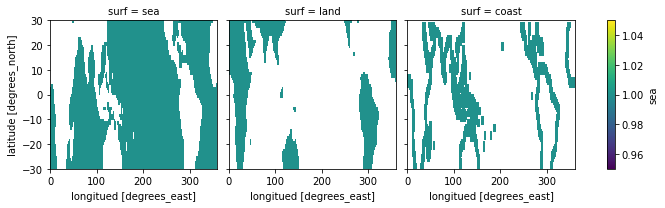

In [136]:
%matplotlib inline
# Smoke tests:
plot_frac = xr.concat([land_frac_new[dvar] for dvar in land_frac_new.data_vars], dim='surf')
plot_frac = plot_frac.assign_coords(dict(surf=list(land_frac_new.data_vars)))
#plot_frac.plot(col='surf', colwrap=3)
plot_frac.plot(col="surf", col_wrap=3, robust=True)

## Create the actual data for the diurnal cycle

In [138]:
df_hour_m = dataset.mean(dim='time')
# Diurnal Amplitude
diurnal_cycle = (dataset.max(dim='time') -  dataset.min(dim='time')) #/ df_hour_m.where(df_hour_m > 0.0001, np.nan)
# Daytime - Nighttime precip
night = dataset.isel(time=list(range(22, 24))+list(range(0, 10))).mean(dim='time')
day = dataset.isel(time=list(range(10, 22))).mean(dim='time')
diff = (day  - night)
dataset['day'] = day[data_var].persist()
dataset['night'] = night[data_var].persist()
dataset['diurnal_cycle'] = diurnal_cycle['pr'].persist()
dataset['diff'] = diff[data_var].persist()
_ = Progress([dataset], notebook=False, label='Loading data')
dataset

<xarray.Dataset>
Dimensions:        (exp: 4, lat: 600, lon: 3600, time: 24)
Coordinates:
  * lon            (lon) float64 0.05 0.15 0.25 0.35 ... 359.7 359.8 359.9 360.0
  * lat            (lat) float64 -29.95 -29.85 -29.75 ... 29.75 29.85 29.95
  * exp            (exp) object 'dpp0014' 'dpp0015' 'dpp0016' 'cmorph'
  * time           (time) datetime64[ns] 2020-02-02 ... 2020-02-02T23:00:00
Data variables:
    pr             (time, exp, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 150), meta=np.ndarray>
    day            (exp, lat, lon) float32 dask.array<chunksize=(1, 600, 150), meta=np.ndarray>
    night          (exp, lat, lon) float32 dask.array<chunksize=(1, 600, 150), meta=np.ndarray>
    diurnal_cycle  (exp, lat, lon) float32 dask.array<chunksize=(1, 600, 150), meta=np.ndarray>
    diff           (exp, lat, lon) float32 dask.array<chunksize=(1, 600, 150), meta=np.ndarray>

In [139]:
# Rename the runs
rename = {'dpp0014': 'Uncoupled run',
          'nwp0005': 'Uncoupled run (nwp)',
          'dpp0016': 'Coupled run (16)',
          'dpp0015': 'Coupled run (15)',
          'cmorph':  'Cmorph'}
new_names = []
for exp in dataset.coords['exp'].values:
    new_names.append(rename[exp])
plot_data = dataset.assign_coords({'exp': new_names})

In [140]:
from da_pipeline.utils import get_minmax 
import dask
minmax = {}
for var, sym in {'pr':True, 'night':False, 'day':False, 'diurnal_cycle':False, 'diff':True}.items():
    minmax[var] = get_minmax(dataset[var].isel(exp=0), dataset[var].sel(exp='cmorph'), symmetric=sym)
minmax = dask.compute(minmax)[0]
minmax

{'pr': (0.0, 1.400316017866131, 2.103324652671816, -2.103324652671816),
 'night': (0.0, 0.8184742510318752, 0.9118393988013517, -0.9118393988013517),
 'day': (0.0, 0.8976497459411559, 1.053093558907549, -1.053093558907549),
 'diurnal_cycle': (0.0,
  2.7398327136039717,
  3.4040879189968334,
  -3.4040879189968334),
 'diff': (-0.6386458253860408,
  0.6386458253860408,
  1.046638273596787,
  -1.046638273596787)}

In [141]:
ttrange = {exp:(df_hour.time[0].values, df_hour.time[-1].values) for exp in exp_names}
ttrange

{'dpp0014': (numpy.datetime64('2020-02-02T00:00:00.000000000'),
  numpy.datetime64('2020-02-02T23:00:00.000000000')),
 'dpp0015': (numpy.datetime64('2020-02-02T00:00:00.000000000'),
  numpy.datetime64('2020-02-02T23:00:00.000000000')),
 'dpp0016': (numpy.datetime64('2020-02-02T00:00:00.000000000'),
  numpy.datetime64('2020-02-02T23:00:00.000000000'))}

## Plotting the data

In [143]:
col_blind = sns.color_palette("colorblind", 10)
sns.set_style('ticks')
sns.set_palette(col_blind)
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 3.5})

In [144]:
def _plot(dset, label, vmax, ax, cmap='Blues', vmin=0):

    plot = dset.sel(exp=label).plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=cmap,
                     vmin=vmin,
                     vmax=vmax,
                     add_colorbar=False)
    ax.coastlines(resolution='10m', lw=0.51)
    ax.set_title(label)
    return plot

def Plotter(data, minmax, exp=['Coupled Run', 'Cmorph'], tstep=None, proj=ccrs.PlateCarree(50),
            cmap='Blues', diff=False, unit='mm/h', label='Precipitation', extend='max'):
    
    ann_kw = dict(xy=(0, 1.13), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=12)
    clabel = f'{label} [{unit}]'
    cdiff = f'Difference [{unit}]'
    cbars = []
    nplots = len(exp)
    cbar_length = 0.95
    fig_height = 5
    if len(exp) > 1 and diff:
        nplots += 1
        cbar_length = 0.45
        fig_height = 8
    if isinstance(tstep, int):
        clabel += f' at {i:02d} LT'
        cdiff += f' at {i:02d} LT'
    fig = plt.figure(figsize=(12, fig_height))  
    plots, axs, cbars = [], [], []
    for nn, (label, ind) in enumerate(zip(exp, ['a)', 'b)'])):
        axs.append(fig.add_subplot(nplots, 1, nn+1, projection=proj))
        plots.append(_plot(data, label, minmax[1], axs[-1], cmap=cmap, vmin=minmax[0]))
        axs[-1].annotate(ind, **ann_kw)
    cax1 = fig.add_axes([0.02, 0.05, cbar_length, 0.02])
    cbars.append(fig.colorbar(plots[-1], cax=cax1, extend=extend, aspect=0.5, label=clabel,
                         orientation='horizontal'))
    if len(exp) > 1 and diff:
        axs.append(fig.add_subplot(nplots, 1, nplots, projection=proj))
        dd = xr.concat([data.sel(exp=exp[0]) - data.sel(exp=exp[1])], dim='exp').assign_coords(dict(exp=['Difference']))
        cax2 = fig.add_axes([0.52, 0.05, cbar_length, 0.02])
        plots.append(_plot(dd, 'Difference', minmax[-2], axs[-1], cmap='RdBu_r', vmin=minmax[-1]))
        axs[-1].set_title(f'Difference ({exp[0]} - {exp[1]})')
        axs[-1].annotate('c)', **ann_kw)
        cbars.append(fig.colorbar(plots[-1], cax=cax2, extend='both', aspect=0.5, label=cdiff,
                         orientation='horizontal'))
        axs[-1].annotate('c)', **ann_kw)
    _ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0.02, wspace=0, top=0.98, bottom=0.05)
    sns.despine()
    return fig

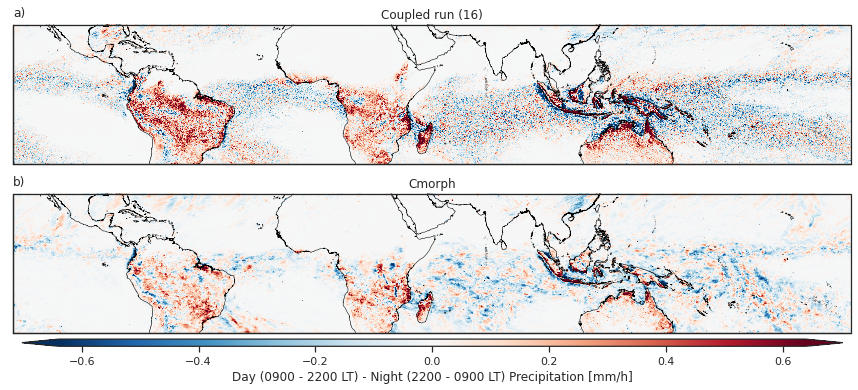

In [145]:
fig = Plotter(plot_data['diff'], minmax['diff'], diff=False, cmap='RdBu_r', exp=['Coupled run (16)', 'Cmorph'],
             label='Day (0900 - 2200 LT) - Night (2200 - 0900 LT) Precipitation', extend='both')
out_d = Path(SCRATCH_DIR) / 'Diurnal_cycle'
out_d.mkdir(exist_ok=True, parents=True)
out_ff = out_d / f'Diurnal_Mori.png'
_ = fig.savefig(str(out_ff), dpi=300, format='png', bbox_inches='tight')

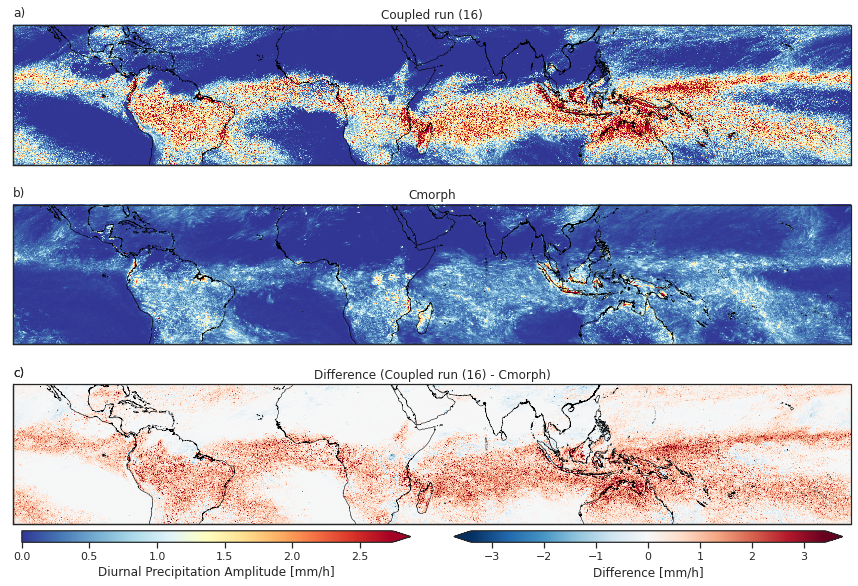

In [146]:
fig = Plotter(plot_data['diurnal_cycle'], minmax['diurnal_cycle'], diff=True, cmap='RdYlBu_r',
              exp=['Coupled run (16)', 'Cmorph'],
             label='Diurnal Precipitation Amplitude', extend='max')
out_d = Path(SCRATCH_DIR) / 'Diurnal_cycle'
out_d.mkdir(exist_ok=True, parents=True)
out_ff = out_d / f'Diurnal_Amplitude_2.png'
_ = fig.savefig(str(out_ff), dpi=300, format='png', bbox_inches='tight')

In [147]:
%matplotlib inline
for i in range(plot_data.dims['time']):
    out_d = Path(SCRATCH_DIR) / 'Diurnal_cycle'
    out_d.mkdir(exist_ok=True, parents=True)
    out_ff = out_d / f'Diurnal_cycle_pr_{i:02d}.png'
    print(f'Creating {out_ff}', end='\r')
    fig = Plotter(plot_data['pr'].isel(time=i), minmax['pr'], tstep=i, exp=['Coupled run (16)', 'Cmorph'])
    _ = fig.savefig(str(out_ff), dpi=300, format='png', bbox_inches='tight')
    _ = fig.clf()

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [199]:
def embed_mp4_as_gif(filename):
    """ Makes a temporary gif version of an mp4 using ffmpeg for embedding in
    IPython. Intended for use in Jupyter notebooks. """
    if not os.path.exists(filename):
        print('file does not exist.')
        return

    dirname = os.path.dirname(filename)
    basename = os.path.basename(filename)
    newfile = NamedTemporaryFile()
    newname = newfile.name + '.gif'
    if len(dirname) != 0:
        os.chdir(dirname)

    os.system('ffmpeg -i ' + basename + ' ' + newname)

    try:
        with open(newname, 'rb') as f:
            display(Image(f.read()))
    finally:
        os.remove(newname)
def create_animation(inp_files, out_mov, res=(800, 452)):
    """Create an animation of given input files."""
    fmpeg_command = ('ffmpeg' ,'-y', '-framerate', '5', '-pattern_type', 'glob', '-i',
                  f'"{inp_files}"', '-crf', '5', '-vcodec', 'libx264',
                  '-pix_fmt', 'yuv420p', '-s', f'{res[0]}x{res[1]}', '-probesize', '100M', f'{out_mov}')
    env_extra = os.environ.copy()
    path_extra=Path(sys.exec_prefix)/'bin'
    env_extra['PATH'] = str(path_extra) + ':' + env_extra['PATH']
    status = run(shlex.split(' '.join(ffmpeg_command)), check=True, stderr=PIPE,
                 stdout=PIPE, env=env_extra, cwd=Path(SCRATCH_DIR) / 'Diurnal_cycle')
    return status.stderr.decode('utf-8')
    

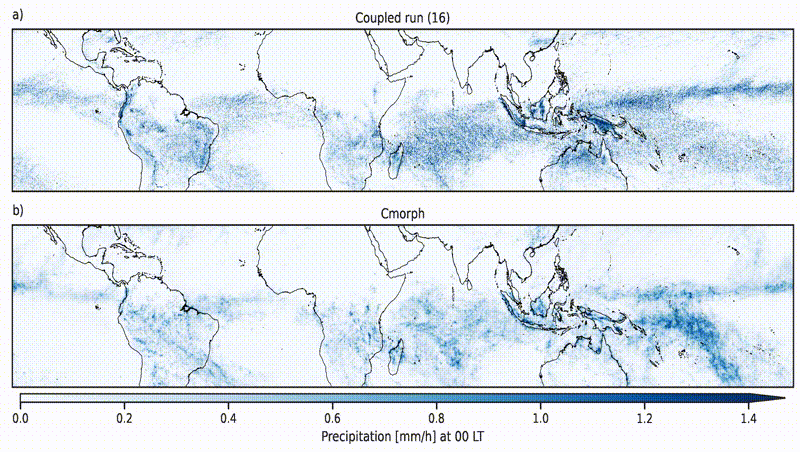

In [206]:
inp_files = out_d / f'Diurnal_cycle_{data_var}_*.png'
out_mov = out_d / f'Diurnal_cycle_{data_var}.mp4'
status = create_animation(inp_files, out_mov)
display(HTML('<h2>Animation of Diurnal Cycle</h2>'))
embed_mp4_as_gif(out_mov)

In [207]:
## Prepare the Time-Series Plot

In [218]:
ts = {'Land+Sea': dataset[data_var].mean(dim=('lat', 'lon'))}
cmip_ts = {'Land+Sea': cmip_remap[data_var].mean(dim=('lat', 'lon'))}
for surf in ('Land', 'Sea', 'Coast'):
    mask = np.ma.masked_invalid(land_frac_new[surf.lower()].values)[np.newaxis, np.newaxis,:]
    ts[surf] = (dataset[data_var] * mask).mean(dim=('lat', 'lon'), skipna=True)
    cmip_ts[surf] = (cmip_remap[data_var] * mask).mean(dim=('lat', 'lon'), skipna=True)
ts = xr.concat(list(ts.values()), dim='surf').assign_coords({'surf': list(ts.keys())})
cmip_ts = xr.concat(list(cmip_ts.values()), dim='surf').assign_coords({'surf': list(cmip_ts.keys())}).load()
ts = ts.assign_coords(exp=plot_data.coords['exp']).load()
cmip_ts = cmip_ts.assign_coords({'time': cmip_ts['time.hour'].values})
ts = ts.assign_coords({'time': ts['time.hour'].values})

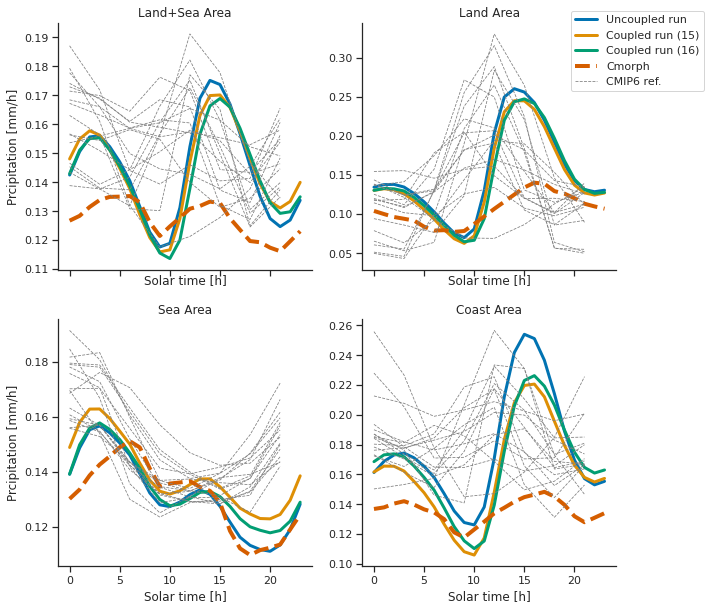

In [219]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=False)
axs = axs.ravel()
for n, surf in enumerate(ts.surf.values):
    plots = []
    for nn, exp in enumerate(ts.coords['exp'].values):
        if exp.lower() == 'cmorph':
            kwargs = dict(linestyle='dashed', linewidth=4, color=col_blind[nn])
        else:
            kwargs = dict(color=col_blind[nn], linewidth=3)
        plots.append(ts.sel(surf=surf, exp=exp).plot(ax=axs[n], hue='exp', add_legend=False, **kwargs)[0])
    for nn, exp in enumerate(cmip_ts.coords['exp'].values):
        pp = cmip_ts.sel(surf=surf, exp=exp).plot(ax=axs[n], hue='exp', add_legend=False, color="grey", linewidth=0.8, linestyle='dashed')
        if nn == 0:
            plots.append(pp[0])
    axs[n].set_xlabel('Solar time [h]')
    axs[n].set_title(f'{surf} Area')
    if n%2 == 0:
        axs[n].set_ylabel('Prcipitation [mm/h]')
    else:
        axs[n].set_ylabel('')
leg = plt.legend(plots, list(ts.exp.values) + ['CMIP6 ref.'], title="", bbox_to_anchor=(0.8, 1.9), loc="lower left")
sns.despine()
out_d = Path(SCRATCH_DIR) / 'Diurnal_cycle'
out_d.mkdir(exist_ok=True, parents=True)
out_ff = out_d / f'Diurnal_ts.png'
_ = fig.savefig(str(out_ff), dpi=300, format='png', bbox_inches='tight')